In [1]:
# Imports
import gym
from gym import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Stock Trading Environment 

In [2]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gym.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing whether the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path  # Path of the CSV file containing the historical stock data.
        self.stock_data = pd.read_csv(self.file_path)  # Reading the CSV file containing the historical stock data.
        self.train = train  # Boolean indicating to use the training stock data by default.
        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()
        self.observation_space = spaces.Discrete(4)  # This defines that there are four states in the environment.
        # This defines that there are 3 discrete actions that the agent can perform (Buy, Sell, Hold).
        self.action_space = spaces.Discrete(3)
        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - (Integer in the range of 0 to 3 representing the four possible observations that the
                                 agent can receive. The observation depends upon whether the price increased on average
                                 in the number of days the agent considers, and whether the agent already has the stock
                                 or not.)"""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector that will be passed to the agent.
            observation = [price_increase, price_decrease, 0, 1]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, 0, 1]
        if np.array_equal(observation, [1, 0, 0, 1]):
            observation = 0
        if np.array_equal(observation, [1, 0, 1, 0]):
            observation = 1
        if np.array_equal(observation, [0, 1, 0, 1]):
            observation = 2
        if np.array_equal(observation, [0, 1, 1, 0]):
            observation = 3

        return observation

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - (Integer in the range 0 to 2 inclusive.)

        :returns observation: - (Integer in the range of 0 to 3 representing the four possible observations that the
                                 agent can receive. The observation depends upon whether the price increased on average
                                 in the number of days the agent considers, and whether the agent already has the stock
                                 or not.)
                 reward: - (Integer/Float value that's used to measure the performance of the agent.)
                 done: - (Boolean describing whether or not the episode has ended.)
                 info: - (A dictionary that can be used to provide additional implementation information.)"""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = 1
            stock_not_held = 0
        else:
            stock_held = 0
            stock_not_held = 1

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, stock_held, stock_not_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, stock_held, stock_not_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [1, 0, 0, 1]):
            observation = 0
        if np.array_equal(observation, [1, 0, 1, 0]):
            observation = 1
        if np.array_equal(observation, [0, 1, 0, 1]):
            observation = 2
        if np.array_equal(observation, [0, 1, 1, 0]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the number of infected people becomes greater than 75 % of the population.
        done = True if (self.timestep >= self.max_timesteps) \
            else False

        info = {}
        return observation, reward, done, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

### Implementing the Q-learning algorithm 

***Algorithm for Q-learning ***
1. Initialize the hyperparameters (alpha, gamma, epsilon), Q Table to zeros (Q Table should be 4x3 matrix since there are 4 states and 3 actions)
2. Iterate through each episode
3. Reset the environment for each episode
4. Iterate through each step-in episode
5. Take a random value if the random value is greater than epsilon then exploit else explore
6. Call the step function in environment to take an action (buy, sell, or hold)
7. Now update the Q Table with the below formulae
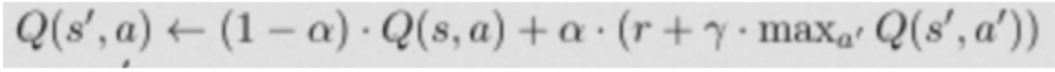

8. Update the state to new state
9. If the loop is done then break it

In [3]:
# Implementing Q-Learning for the stock trading environment.
class QLearning:
    """This class implements the Q-learning algorithm."""
    
    def __init__(self, environment):
        """This method instantiates the Q-learning parameters."""

        self.environment = environment
        #Action size = 3 (buy, sell or hold)
        self.actionCount = environment.action_space.n
        #Observation size = 4 (0,1,2,3)
        self.stateCount = environment.observation_space.n
        #Initilizing Q Table 4 X 3 
        self.QTable = np.zeros((self.stateCount, self.actionCount))
        #Initializing episodes(epochs)
        self.episodes = 1000
        #If we recieve the done then loop will break else it will iterate a Max of 1000 Iterations per episode 
        self.maxIterations = 1000

        #Hyperparameters
        #Learning Rate Alpha
        self.alpha = 0.1
        #Discounting factor gamma
        self.gamma = 0.8
        #Exploration rate epsilon
        self.epsilon = 1.0
        #Min Exploration 
        self.minEpsilon = 0.01
       
        #For plotting the graphs
        #Array to store Episodes
        self.episodesArray = [i for i in range(self.episodes)] 
        #Array to store Rewards
        self.rewardArray = [0 for i in range(self.episodes)]
        #Array to store Epsilon Decay values
        self.epsilonArray = []

    def train(self):
        """This method performs the agent training."""
        
        #Training the Agent
        for episode in range(self.episodes):
          #Reset the environment for every iteration
          state = self.environment.reset()
          print("**********      Episode:",episode,"      *********")
          #This loop will breaks if it is done or it reach the max iterations of 1000
          for iteration in range(self.maxIterations):
            #Exploitation 
            if np.random.uniform(0,1) > self.epsilon:
              action = np.argmax(self.QTable[state,:])
            else: #Exploration 
              action = self.environment.action_space.sample()

            #Call the environment step function and store the returned values
            newState, rewards , done, info = self.environment.step(action)
            #Updating the Q Table 
            #Formulae to calculate the Q Value
            self.QTable[state, action] = (1 - self.alpha) * self.QTable[state, action] + self.alpha * (rewards + self.gamma * max(self.QTable[newState]) - self.QTable[state, action])
            #Adding the reward to the total rewards for plotting the graph
            self.rewardArray[episode] += rewards
            #Assigning the newState to the state, so used for the next iteration
            state = newState
            #Breaking the for loop if the episode has ended
            if done:
               break

          #Reducing the epsilon value, since we need less exploration in every step
          if self.epsilon > self.minEpsilon:
            self.epsilon *= 0.995
          #Storing the Epsilon values in an Arrray
          self.epsilonArray.append(self.epsilon)

        #printing the Q Table
        print("Q Table:")
        print(self.QTable)
       

    def evaluate(self):
        """This method evaluate the trained agent's performance."""
        
        #Flag to enable evaluate
        self.environment.train = False
        #Reset the environment
        state = self.environment.reset()
        #This loop will breaks if it is done or it reach the max iterations of 1000
        for iteration in range(self.maxIterations):
            #exploitation
            action = np.argmax(self.QTable[state,:])
            #Call the environment step function and store the returned values
            newState, rewards , done, info = self.environment.step(action)
            #Formulae to calculate the Q Value
            self.QTable[state, action] = (1 - self.alpha) * self.QTable[state, action] + self.alpha * (rewards + self.gamma * max(self.QTable[newState]) - self.QTable[state, action])
            #Assigning the newState to the state, so used for the next iteration
            state = newState
            #Breaking the for loop if the episode has ended
            if done:
              break


    def plot(self):
        """This method plots the reward dynamics and epsilon decay."""

        #Plotting the Rewards Dynamics with episodes 
        plt.figure(figsize=(11, 7))
        plt.plot(self.episodesArray, self.rewardArray, color='blue', linewidth=2)
        plt.xlabel("Episodes",fontsize=24)
        plt.ylabel("Rewards values",fontsize=24)
        plt.title('Total rewards per episode', fontsize=32)

        print()
        print()
        print()

        #Plotting the Epsilon Decay with episodes 
        plt.figure(figsize=(11, 7))
        plt.plot(self.episodesArray, self.epsilonArray, color='red', linewidth=5)
        plt.xlabel('Episodes', fontsize=24)
        plt.ylabel('Epsilon values', fontsize=24)
        plt.title('Epsilon Decay', fontsize=32)
        plt.show()

In [4]:
stock_trading_environment = StockTradingEnvironment('./NVDA.csv', number_of_days_to_consider=10)
print("Initial Total Account Value: ",stock_trading_environment.total_account_value)

Initial Total Account Value:  100000


In [5]:
QLearning = QLearning(stock_trading_environment)
#Train the Model
QLearning.train()

**********      Episode: 0       *********
**********      Episode: 1       *********
**********      Episode: 2       *********
**********      Episode: 3       *********
**********      Episode: 4       *********
**********      Episode: 5       *********
**********      Episode: 6       *********
**********      Episode: 7       *********
**********      Episode: 8       *********
**********      Episode: 9       *********
**********      Episode: 10       *********
**********      Episode: 11       *********
**********      Episode: 12       *********
**********      Episode: 13       *********
**********      Episode: 14       *********
**********      Episode: 15       *********
**********      Episode: 16       *********
**********      Episode: 17       *********
**********      Episode: 18       *********
**********      Episode: 19       *********
**********      Episode: 20       *********
**********      Episode: 21       *********
**********      Episode: 22       ********

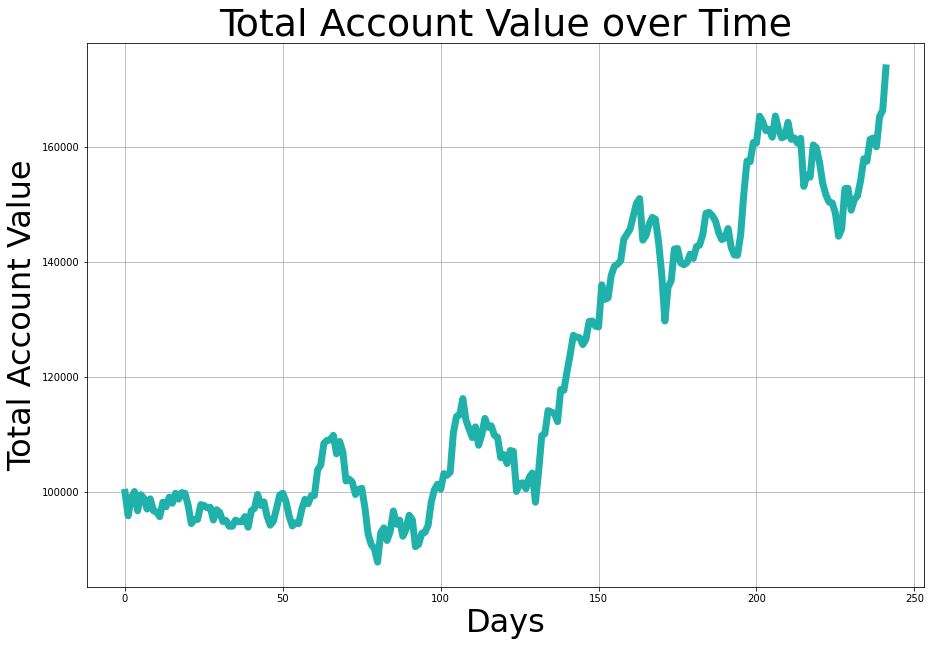

Total Account value after Evaluating:  173752.21279800002


In [6]:
print()
QLearning.evaluate()
stock_trading_environment.render(QLearning)
#Printing the Total Account Value after evaluating
print("Total Account value after Evaluating: ",stock_trading_environment.total_account_value)

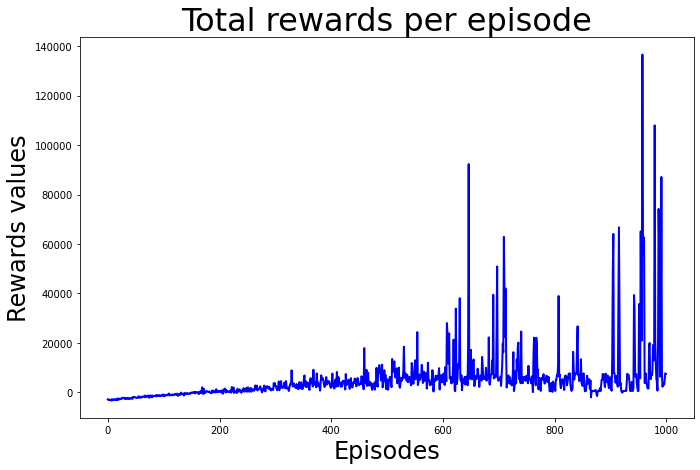

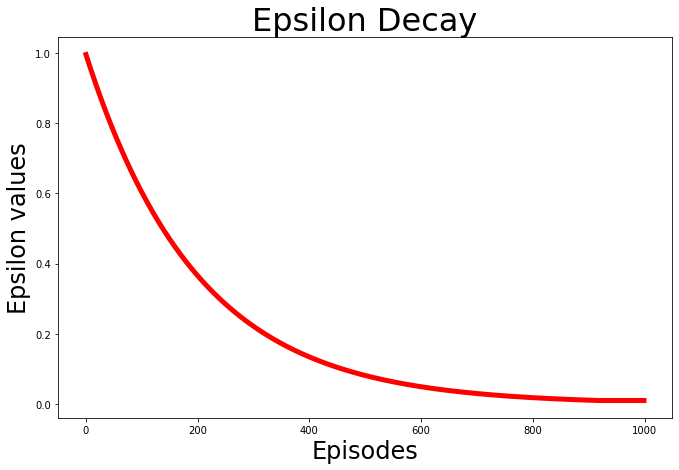

In [7]:
QLearning.plot()